In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from data.small_context import get_bitcoin_datasets
from data.small_context import get_bitcoin_datasets_hourly

from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False, save_index = 0):
    save_folder = "./plot/" + str(save_index)
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig(save_folder)
    plt.show()


/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


## Define models ##

In [2]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-004', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-004', **promptcast_hypers},
    # 'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    # 'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 610 and forecasting on 72 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Model :  LLMTime GPT-3.5
Sequence lenght :  488
(' 4 3 1 , 4 2 6 , 4 2 9 , 3 5 5 , 4 2 9 , 4 3 0 , 4 3 7 , 4 0 2 , 4 0 6 , 4 2 3 , 3 9 9 , 3 8 5 , 3 9 5 , 4 0 5 , 4 1 6 , 4 4 8 , 4 5 7 , 4 7 3 , 4 6 9 , 4 3 1 , 4 6 7 , 4 4 0 , 4 1 7 , 4 1 8 , 4 1 2 , 4 3 3 , 4 2 7 , 4 2 8 , 4 4 8 , 4 2 9 , 4 0 8 , 4 1 1 , 3 8 4 , 4 0 6 , 4 0 1 , 4 0 2 , 4 1 6 , 4 1 0 , 4 0 3 , 3 7 7 , 3 4 4 , 3 4 4 , 3 6 5 , 3 7 8 , 3 8 6 , 3 6 4 , 3 5 4 , 3 9 1 , 5 0 1 , 5 1 9 , 5 5 8 , 5 2 6 , 4 8 8 , 5 0 7 , 5 0 2 , 5 0 3 , 4 8 8 , 4 7 9 , 4 9 7 , 4 7 9 , 4 8 1 , 4 7 0 , 4 8 3 , 4 8 6 , 5 0 8 , 4 9 3 , 5 0 5 , 5 0 9 , 4 8 9 , 4 7 0 , 5 0 6 , 4 8 7 , 5 4 5 , 5 5 2 , 5 5 3 , 5 4 6 , 5 8 6 , 5 5 5 , 6 0 5 , 6 1 7 , 7 1 2 , 7 2 8 , 7 8 7 , 7 5 7 , 7 9 4 , 7 4 8 , 7 7 6 , 8 1 1 , 7 9 6 , 8 0 4 , 8 2 1 , 8 8 2 , 1 0 2 7 , 8 6 5 , 7 0 4 , 7 6 9 , 7 1 0 , 7 1 4 , 7 4 9 , 7 4 4 , 7 4 7 , 7 7 6 , 7 3 6 , 7 7 7 , 8 1 1 , 7 8 8 , 7 9 5 , 7 9 0 , 7 5 9 , 7 2 5 , 7 4 1 , 7 4 8 , 7 9 2 , 8 5 5 , 8 8 3 , 8 3 7 , 8 5 8 , 8 5 9 , 9 2

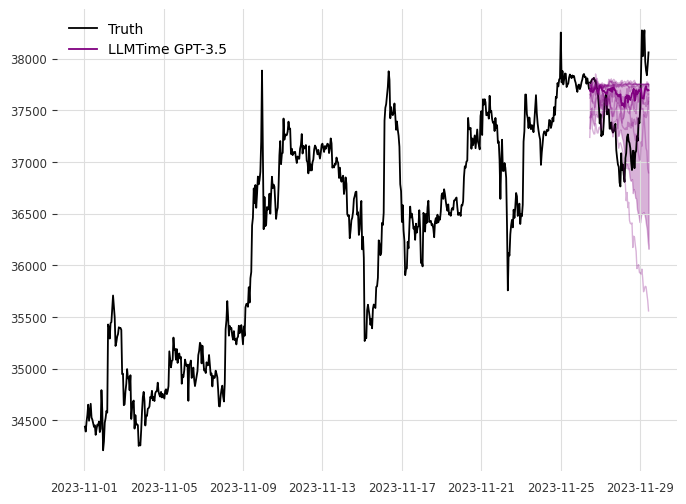

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:10<00:00, 10.14s/it]


Model :  LLMTime GPT-4
Sequence lenght :  610
('972, 971, 974, 976, 978, 974, 976, 979, 975, 974, 973, 972, 973, 970, 972, 973, 973, 974, 971, 972, 982, 977, 966, 968, 973, 975, 977, 976, 1000, 1000, 996, 1001, 1001, 1005, 1008, 1005, 1002, 994, 995, 997, 998, 999, 999, 999, 999, 987, 987, 978, 978, 982, 984, 988, 985, 986, 982, 986, 974, 977, 979, 979, 972, 975, 973, 973, 973, 967, 968, 967, 971, 976, 980, 982, 979, 973, 975, 975, 977, 977, 978, 980, 980, 982, 980, 980, 979, 981, 982, 982, 984, 982, 981, 981, 982, 980, 981, 981, 980, 982, 983, 981, 982, 983, 993, 991, 989, 990, 991, 997, 993, 994, 991, 994, 990, 991, 992, 991, 991, 984, 986, 986, 988, 991, 990, 989, 989, 979, 989, 989, 990, 986, 986, 988, 985, 983, 985, 986, 988, 992, 993, 995, 995, 990, 994, 991, 988, 988, 987, 990, 989, 989, 992, 989, 986, 987, 983, 986, 986, 986, 988, 987, 986, 982, 978, 978, 981, 982, 984, 981, 979, 984, 999, 1001, 1007, 1002, 997, 1000, 999, 999, 997, 996, 998, 996, 996, 995, 997, 997, 1000, 998,

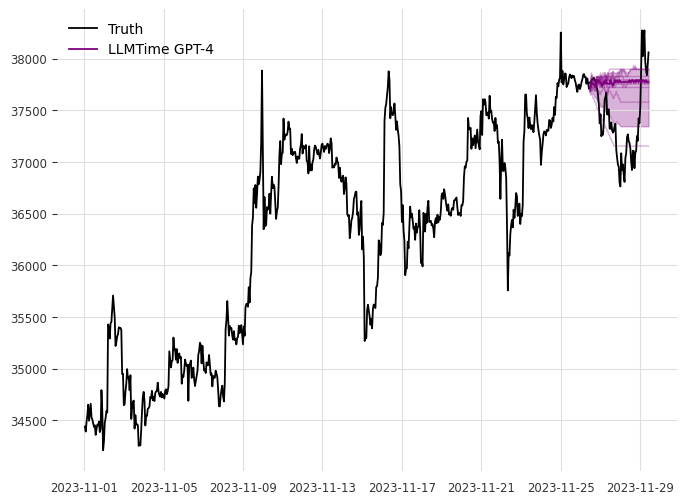

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 562 and forecasting on 120 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:13<00:00, 13.99s/it]


Model :  LLMTime GPT-3.5
Sequence lenght :  430
(' 4 1 1 , 3 9 6 , 4 0 8 , 4 1 8 , 4 3 0 , 4 6 5 , 4 7 5 , 4 9 3 , 4 8 8 , 4 4 7 , 4 8 6 , 4 5 6 , 4 3 1 , 4 3 3 , 4 2 5 , 4 4 9 , 4 4 3 , 4 4 3 , 4 6 6 , 4 4 5 , 4 2 1 , 4 2 4 , 3 9 6 , 4 1 9 , 4 1 4 , 4 1 5 , 4 3 1 , 4 2 4 , 4 1 6 , 3 8 7 , 3 5 2 , 3 5 1 , 3 7 4 , 3 8 8 , 3 9 7 , 3 7 3 , 3 6 2 , 4 0 3 , 5 2 3 , 5 4 3 , 5 8 5 , 5 5 0 , 5 0 9 , 5 3 0 , 5 2 4 , 5 2 6 , 5 0 9 , 5 0 0 , 5 1 9 , 4 9 9 , 5 0 1 , 4 8 9 , 5 0 3 , 5 0 6 , 5 3 1 , 5 1 4 , 5 2 7 , 5 3 2 , 5 1 0 , 4 8 9 , 5 2 9 , 5 0 8 , 5 7 1 , 5 7 9 , 5 8 0 , 5 7 3 , 6 1 6 , 5 8 2 , 6 3 7 , 6 5 0 , 7 5 4 , 7 7 1 , 8 3 6 , 8 0 4 , 8 4 4 , 7 9 3 , 8 2 5 , 8 6 3 , 8 4 6 , 8 5 5 , 8 7 4 , 9 4 1 , 1 0 9 9 , 9 2 2 , 7 4 6 , 8 1 7 , 7 5 2 , 7 5 6 , 7 9 5 , 7 8 9 , 7 9 3 , 8 2 5 , 7 8 0 , 8 2 5 , 8 6 3 , 8 3 7 , 8 4 5 , 8 4 0 , 8 0 6 , 7 6 9 , 7 8 6 , 7 9 4 , 8 4 2 , 9 1 0 , 9 4 2 , 8 9 1 , 9 1 4 , 9 1 6 , 9 9 2 , 9 4 5 , 9 5 7 , 9 5 5 , 9 5 6 , 9 6 4 , 9 8 5 , 9 6 9 , 9 7 0 , 9 1 3 , 9 2

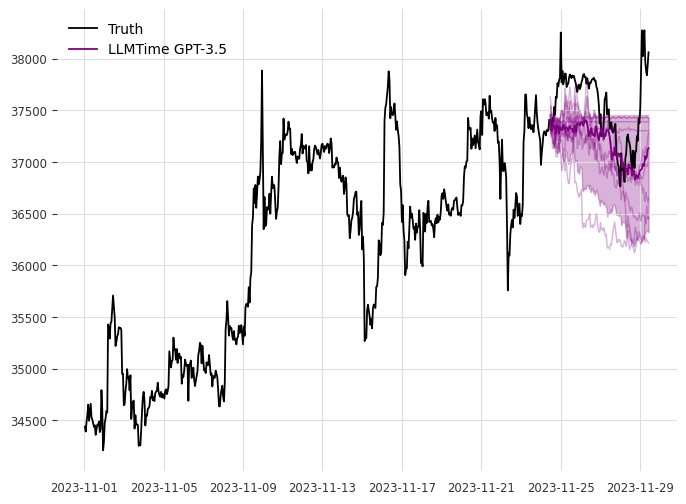

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:22<00:00, 22.92s/it]


Model :  LLMTime GPT-4
Sequence lenght :  562
('975, 973, 976, 978, 981, 976, 978, 981, 977, 976, 975, 974, 975, 972, 974, 975, 975, 976, 973, 974, 985, 979, 968, 971, 976, 977, 979, 978, 1003, 1002, 999, 1003, 1003, 1007, 1010, 1007, 1005, 997, 998, 999, 1000, 1002, 1002, 1002, 1001, 989, 989, 980, 981, 984, 986, 990, 988, 988, 985, 989, 977, 980, 981, 982, 974, 978, 975, 975, 975, 969, 970, 969, 974, 979, 983, 984, 982, 975, 978, 978, 979, 980, 980, 983, 982, 984, 982, 983, 982, 984, 984, 984, 987, 984, 983, 983, 984, 983, 984, 983, 982, 984, 985, 983, 984, 986, 995, 993, 991, 993, 993, 999, 996, 996, 993, 996, 992, 994, 995, 993, 994, 986, 989, 988, 990, 993, 992, 991, 992, 982, 992, 992, 993, 988, 989, 991, 988, 986, 987, 988, 990, 994, 995, 998, 997, 992, 997, 993, 990, 990, 989, 992, 991, 991, 994, 992, 989, 989, 986, 988, 988, 988, 990, 989, 988, 985, 980, 980, 983, 985, 986, 983, 981, 987, 1001, 1004, 1009, 1005, 1000, 1002, 1001, 1002, 1000, 998, 1001, 998, 999, 997, 999, 999,

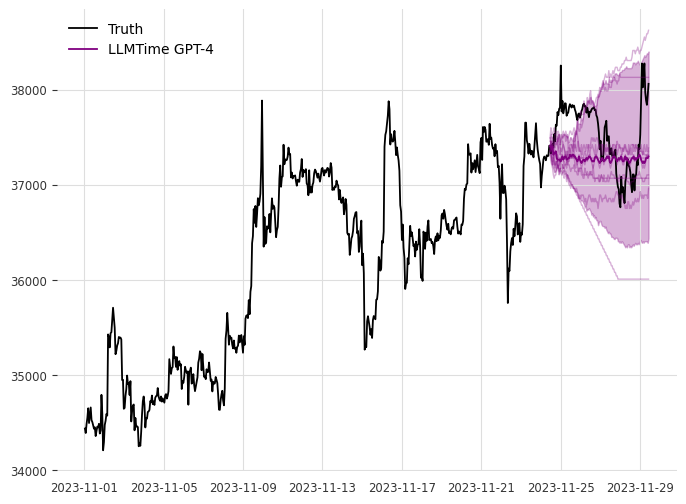

Data set : BTC_Daily_ohlc
from 2023-11-01 01:00:00 to 2023-11-29 10:00:00
682 data points, training on 514 and forecasting on 168 points
Imput is scaled closing price
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:19<00:00, 19.52s/it]


Model :  LLMTime GPT-3.5
Sequence lenght :  372
(' 4 8 9 , 4 5 9 , 4 3 4 , 4 3 5 , 4 2 8 , 4 5 2 , 4 4 5 , 4 4 6 , 4 6 8 , 4 4 7 , 4 2 4 , 4 2 7 , 3 9 8 , 4 2 1 , 4 1 6 , 4 1 8 , 4 3 3 , 4 2 6 , 4 1 8 , 3 9 0 , 3 5 4 , 3 5 3 , 3 7 7 , 3 9 1 , 4 0 0 , 3 7 6 , 3 6 4 , 4 0 5 , 5 2 6 , 5 4 6 , 5 8 9 , 5 5 4 , 5 1 2 , 5 3 3 , 5 2 7 , 5 2 9 , 5 1 2 , 5 0 3 , 5 2 2 , 5 0 2 , 5 0 4 , 4 9 2 , 5 0 6 , 5 0 9 , 5 3 4 , 5 1 7 , 5 3 0 , 5 3 5 , 5 1 3 , 4 9 2 , 5 3 2 , 5 1 1 , 5 7 5 , 5 8 3 , 5 8 3 , 5 7 6 , 6 2 0 , 5 8 6 , 6 4 0 , 6 5 4 , 7 5 9 , 7 7 6 , 8 4 2 , 8 0 8 , 8 4 9 , 7 9 8 , 8 2 9 , 8 6 8 , 8 5 1 , 8 6 0 , 8 7 9 , 9 4 6 , 1 1 0 6 , 9 2 7 , 7 5 0 , 8 2 2 , 7 5 7 , 7 6 0 , 8 0 0 , 7 9 4 , 7 9 8 , 8 3 0 , 7 8 5 , 8 3 0 , 8 6 8 , 8 4 2 , 8 5 0 , 8 4 5 , 8 1 0 , 7 7 3 , 7 9 0 , 7 9 8 , 8 4 7 , 9 1 6 , 9 4 8 , 8 9 6 , 9 1 9 , 9 2 1 , 9 9 8 , 9 5 1 , 9 6 3 , 9 6 0 , 9 6 1 , 9 6 9 , 9 9 1 , 9 7 5 , 9 7 6 , 9 1 9 , 9 3 0 , 9 1 6 , 9 2 3 , 9 2 2 , 9 2 4 , 9 1 0 , 8 9 9 , 9 1 3 , 9 0 9 , 9 0 8 , 9 3

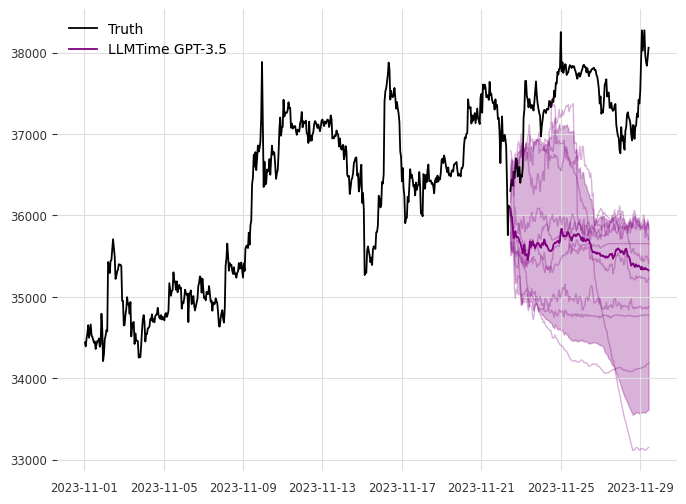

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_BitHourly'}) 
 with NLL inf


100%|██████████| 1/1 [00:22<00:00, 22.63s/it]


Model :  LLMTime GPT-4
Sequence lenght :  514
('977, 975, 978, 980, 983, 978, 980, 983, 979, 978, 977, 976, 977, 974, 976, 977, 977, 978, 975, 976, 987, 981, 970, 972, 978, 979, 981, 980, 1005, 1004, 1001, 1005, 1005, 1009, 1013, 1010, 1007, 999, 1000, 1001, 1002, 1004, 1004, 1004, 1003, 991, 991, 982, 983, 986, 988, 992, 990, 990, 987, 991, 979, 982, 983, 984, 976, 980, 977, 977, 977, 971, 972, 971, 976, 981, 985, 986, 984, 977, 980, 979, 981, 982, 982, 985, 984, 986, 984, 985, 984, 986, 986, 986, 989, 986, 985, 985, 986, 985, 985, 985, 984, 986, 987, 985, 986, 988, 997, 995, 993, 994, 995, 1001, 998, 998, 995, 998, 994, 996, 997, 995, 996, 988, 991, 990, 992, 995, 994, 993, 994, 984, 994, 994, 995, 990, 991, 993, 989, 988, 989, 990, 992, 996, 997, 1000, 999, 994, 999, 995, 992, 992, 991, 994, 993, 993, 996, 994, 991, 991, 988, 990, 990, 990, 992, 991, 990, 987, 982, 982, 985, 987, 988, 985, 983, 988, 1003, 1006, 1011, 1007, 1002, 1004, 1003, 1004, 1002, 1000, 1003, 1000, 1001, 999, 1

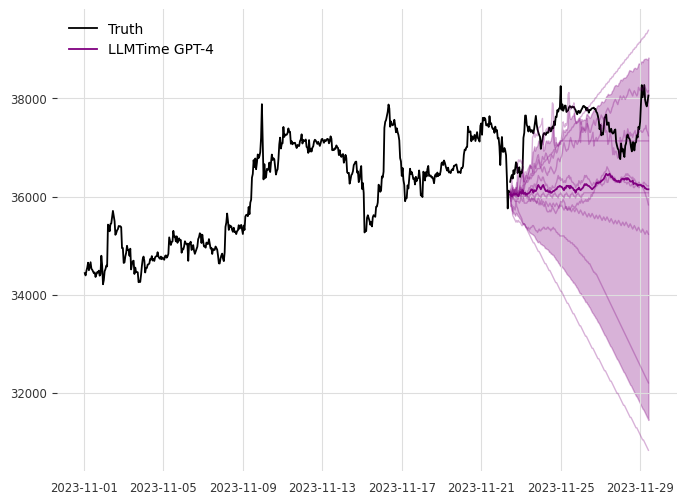

In [15]:
# datasets = get_bitcoin_datasets(predict_steps=30, start_date="2024-02-01")
# ds_name = 'BTC_BitHourly'
starting_date = '2023-11-01'
index = 0
for predict_step in [72,120,168] :

    with open(f"datasets/bitcoin/BTC_BitHourly.csv") as f:
        df = pd.read_csv(f, usecols=[0, 5], parse_dates=[0])
        mask = (df["timestamp"] > starting_date) 
        df = df.loc[mask]

        start_date = df["timestamp"].iloc[0]
        end_date = df["timestamp"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

    datasets = get_bitcoin_datasets_hourly(predict_steps=predict_step, timestamp="2023-11-01")
    ds_name = 'BTC_BitHourly'


    data = datasets[ds_name]
    train, test = data # or change to your own data
    out = {}
    for i,model in enumerate(model_names): # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict

        print("Model : ", model)
        string = out[model]['input_strs']
        string = str(string)
        number_comma = 0
        for elt in string :
            # print(elt)
            if elt == ',' :
                number_comma += 1
        print("Sequence lenght : ", number_comma - 1)
        print(string)

        index += 1
        plot_preds(train, test, pred_dict, model, show_samples=True, save_index=index)



        


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


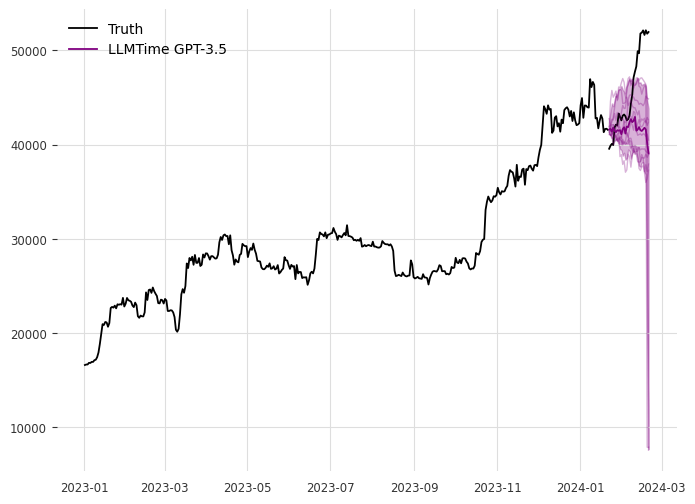

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]

<Figure size 640x480 with 0 Axes>

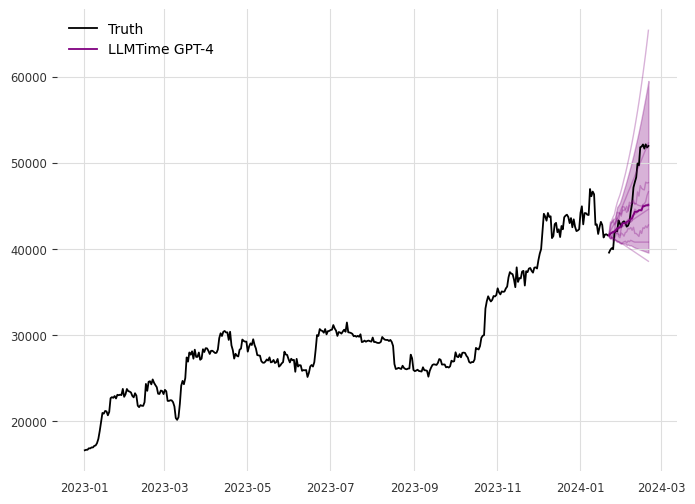

Model :  LLMTime GPT-3.5
Sequence lenght :  386
(' 2 5 2 , 2 5 4 , 2 5 4 , 2 5 9 , 2 5 8 , 2 6 1 , 2 6 1 , 2 6 6 , 2 6 8 , 2 7 5 , 2 8 9 , 3 1 4 , 3 4 4 , 3 7 3 , 3 7 0 , 3 7 9 , 3 7 8 , 3 6 5 , 3 7 6 , 4 2 0 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 9 , 4 3 1 , 4 3 0 , 4 3 1 , 4 3 0 , 4 5 0 , 4 2 4 , 4 3 3 , 4 5 0 , 4 4 3 , 4 4 1 , 4 3 8 , 4 2 7 , 4 2 3 , 4 3 6 , 4 2 8 , 3 9 6 , 3 9 1 , 3 9 8 , 3 9 6 , 3 9 5 , 4 0 7 , 4 6 6 , 4 4 4 , 4 7 3 , 4 7 5 , 4 6 5 , 4 8 0 , 4 7 0 , 4 6 2 , 4 5 5 , 4 3 4 , 4 3 4 , 4 4 5 , 4 4 3 , 4 3 3 , 4 4 7 , 4 4 2 , 4 1 1 , 4 1 1 , 4 1 4 , 4 1 3 , 4 0 7 , 3 9 3 , 3 5 6 , 3 5 0 , 3 5 9 , 4 0 2 , 4 6 0 , 4 7 6 , 4 6 5 , 4 8 5 , 5 5 1 , 5 3 8 , 5 6 7 , 5 6 0 , 5 7 1 , 5 4 7 , 5 7 6 , 5 5 3 , 5 5 3 , 5 6 7 , 5 4 4 , 5 4 8 , 5 7 8 , 5 6 9 , 5 8 1 , 5 8 1 , 5 7 3 , 5 6 3 , 5 7 3 , 5 7 3 , 5 6 9 , 5 6 6 , 5 6 6 , 5 7 7 , 6 1 4 , 6 2 9 , 6 2 1 , 6 3 4 , 6 3 7 , 6 3 2 , 6 3 2 , 6 0 8 , 6 3 4 , 5 9 0 , 5 7 5 , 5 4 8 , 5 6 3 , 5 5 7 , 5 5 5 , 5 7 6 , 5 8 0 , 6 0 9 , 6 0 5 , 6 0 2

100%|██████████| 1/1 [00:14<00:00, 14.16s/it]

<Figure size 640x480 with 0 Axes>

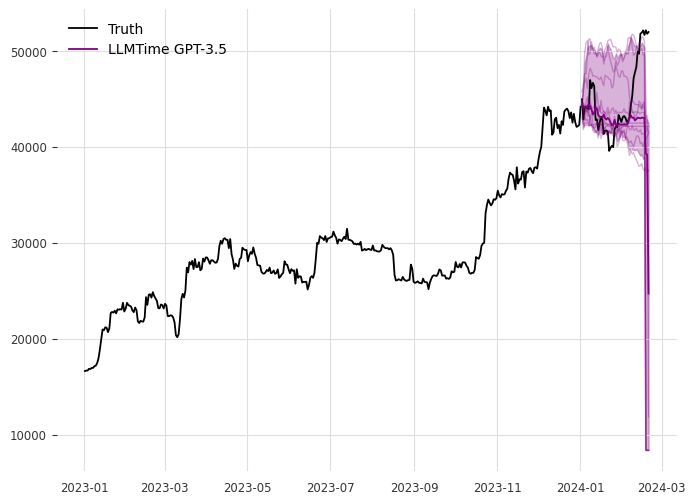

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:09<00:00,  9.30s/it]

<Figure size 640x480 with 0 Axes>

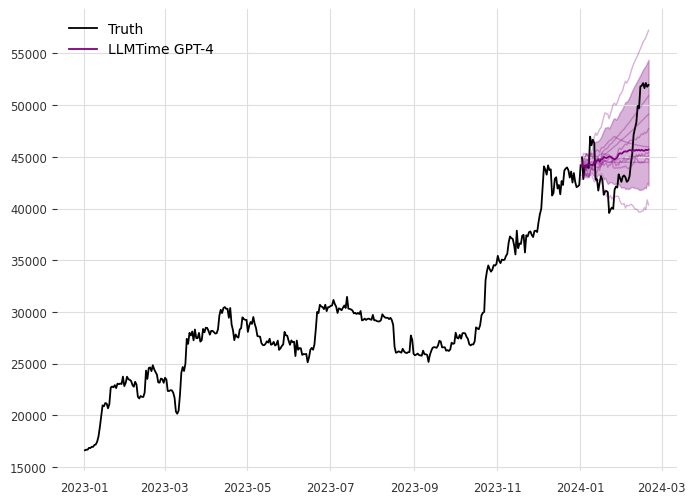

Model :  LLMTime GPT-3.5
Sequence lenght :  366
(' 2 4 2 , 2 4 4 , 2 4 4 , 2 4 9 , 2 4 8 , 2 5 2 , 2 5 2 , 2 5 7 , 2 5 8 , 2 6 6 , 2 8 1 , 3 0 7 , 3 3 9 , 3 6 9 , 3 6 7 , 3 7 6 , 3 7 4 , 3 6 1 , 3 7 3 , 4 1 9 , 4 2 3 , 4 2 1 , 4 2 7 , 4 1 8 , 4 3 1 , 4 2 9 , 4 3 1 , 4 3 0 , 4 5 1 , 4 2 4 , 4 3 3 , 4 5 1 , 4 4 3 , 4 4 2 , 4 3 9 , 4 2 7 , 4 2 2 , 4 3 6 , 4 2 8 , 3 9 4 , 3 8 9 , 3 9 6 , 3 9 3 , 3 9 3 , 4 0 6 , 4 6 8 , 4 4 4 , 4 7 5 , 4 7 7 , 4 6 6 , 4 8 3 , 4 7 2 , 4 6 4 , 4 5 7 , 4 3 5 , 4 3 4 , 4 4 5 , 4 4 4 , 4 3 3 , 4 4 8 , 4 4 3 , 4 1 0 , 4 1 0 , 4 1 2 , 4 1 2 , 4 0 6 , 3 9 1 , 3 5 2 , 3 4 6 , 3 5 5 , 4 0 0 , 4 6 2 , 4 7 8 , 4 6 7 , 4 8 8 , 5 5 8 , 5 4 4 , 5 7 5 , 5 6 7 , 5 7 9 , 5 5 4 , 5 8 4 , 5 6 0 , 5 6 0 , 5 7 5 , 5 5 0 , 5 5 4 , 5 8 6 , 5 7 7 , 5 8 9 , 5 8 9 , 5 8 1 , 5 7 0 , 5 8 1 , 5 8 1 , 5 7 7 , 5 7 3 , 5 7 4 , 5 8 5 , 6 2 4 , 6 4 0 , 6 3 1 , 6 4 5 , 6 4 8 , 6 4 3 , 6 4 3 , 6 1 8 , 6 4 6 , 5 9 9 , 5 8 3 , 5 5 4 , 5 7 0 , 5 6 4 , 5 6 1 , 5 8 5 , 5 8 8 , 6 1 9 , 6 1 4 , 6 1 2

100%|██████████| 1/1 [00:14<00:00, 14.53s/it]

<Figure size 640x480 with 0 Axes>

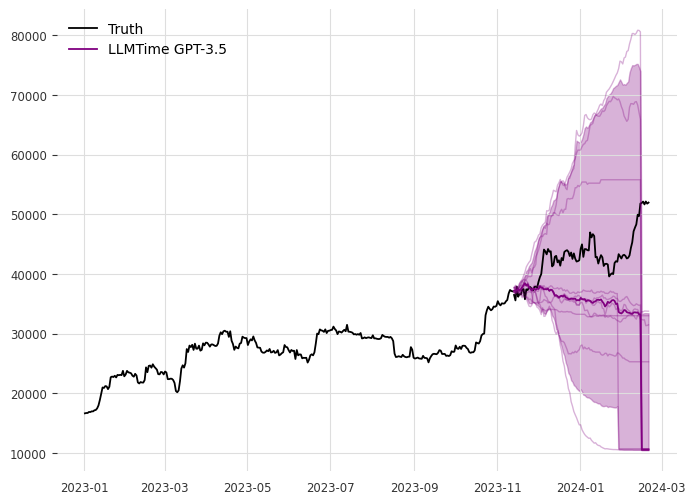

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'BTC_Daily_ohlc'}) 
 with NLL inf


100%|██████████| 1/1 [00:22<00:00, 22.34s/it]

<Figure size 640x480 with 0 Axes>

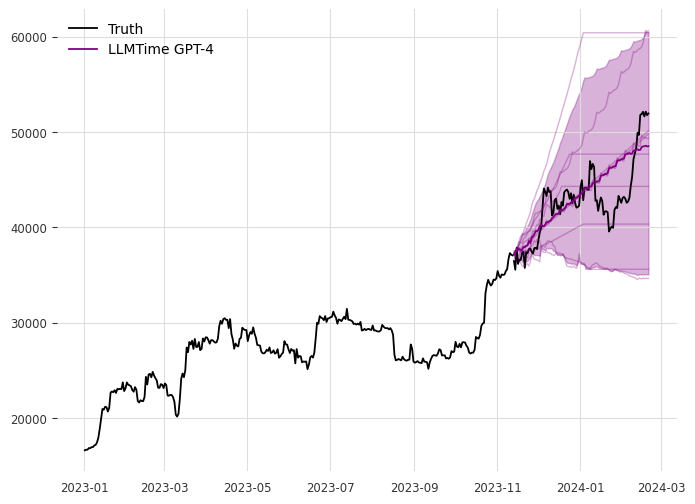

Model :  LLMTime GPT-3.5
Sequence lenght :  316
(' 2 6 0 , 2 6 2 , 2 6 2 , 2 7 0 , 2 6 9 , 2 7 4 , 2 7 4 , 2 8 1 , 2 8 4 , 2 9 5 , 3 1 6 , 3 5 4 , 3 9 9 , 4 4 2 , 4 3 9 , 4 5 2 , 4 5 0 , 4 3 0 , 4 4 7 , 5 1 4 , 5 1 9 , 5 1 6 , 5 2 4 , 5 1 3 , 5 3 1 , 5 2 8 , 5 3 1 , 5 2 9 , 5 5 9 , 5 2 1 , 5 3 3 , 5 5 9 , 5 4 8 , 5 4 6 , 5 4 2 , 5 2 5 , 5 1 8 , 5 3 8 , 5 2 6 , 4 7 7 , 4 7 0 , 4 8 0 , 4 7 7 , 4 7 6 , 4 9 4 , 5 8 4 , 5 5 0 , 5 9 4 , 5 9 6 , 5 8 1 , 6 0 5 , 5 8 9 , 5 7 8 , 5 6 7 , 5 3 6 , 5 3 5 , 5 5 1 , 5 4 9 , 5 3 4 , 5 5 4 , 5 4 7 , 5 0 1 , 5 0 1 , 5 0 4 , 5 0 3 , 4 9 4 , 4 7 4 , 4 1 7 , 4 0 8 , 4 2 1 , 4 8 6 , 5 7 5 , 5 9 8 , 5 8 2 , 6 1 2 , 7 1 2 , 6 9 2 , 7 3 7 , 7 2 6 , 7 4 2 , 7 0 6 , 7 5 0 , 7 1 5 , 7 1 5 , 7 3 7 , 7 0 1 , 7 0 7 , 7 5 2 , 7 3 9 , 7 5 7 , 7 5 7 , 7 4 5 , 7 2 9 , 7 4 5 , 7 4 5 , 7 3 9 , 7 3 4 , 7 3 5 , 7 5 1 , 8 0 7 , 8 3 0 , 8 1 7 , 8 3 8 , 8 4 1 , 8 3 4 , 8 3 5 , 7 9 8 , 8 3 8 , 7 7 1 , 7 4 8 , 7 0 7 , 7 3 0 , 7 2 1 , 7 1 7 , 7 5 0 , 7 5 5 , 8 0 0 , 7 9 3 , 7 9 0

<Figure size 640x480 with 0 Axes>

In [32]:
index = 0
for predict_step in [30,50,100] :
    starting_date = "2023-01-01"
    datasets = get_bitcoin_datasets(predict_steps=predict_step, start_date=starting_date)
    ds_name = 'BTC_Daily_ohlc'

    data = datasets[ds_name]
    train, test = data # or change to your own data
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        index += 1
        plot_preds(train, test, pred_dict, model, show_samples=True, save_index=index)


    for model in model_names[:-1]: # GPT-4 takes a about a minute to run
        print("Model : ", model)
        string = out[model]['input_strs']
        string = str(string)
        number_comma = 0
        for elt in string :
            # print(elt)
            if elt == ',' :
                number_comma += 1
        print("Sequence lenght : ", number_comma - 1)
        print(string)


    with open(f"datasets/bitcoin/BTC_Daily_ohlc.csv") as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] > starting_date) 
        df = df.loc[mask]

        start_date = df["date"].iloc[0]
        end_date = df["date"].iloc[-1]

        print("Data set : BTC_Daily_ohlc")
        print(f"from {start_date} to {end_date}")
        print(f"{df.shape[0]} data points, training on {df.shape[0]- predict_step} and forecasting on {predict_step} points")
        print("Imput is scaled closing price")

        # df['close'] = df['close'].astype(float)
        # series = pd.Series(df['close'].values, index=df['date'])


## Running LLMTime and Visualizing Results ##

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-3.5-turbo-instruct', 'temp': 0.7, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


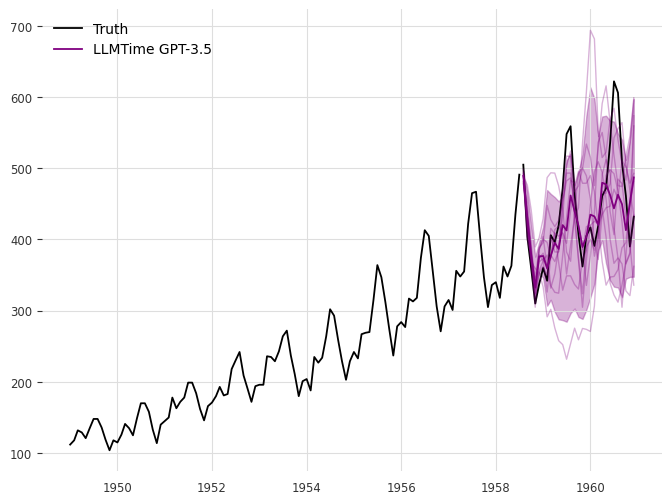

Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'AirPassengersDataset'}) 
 with NLL inf


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


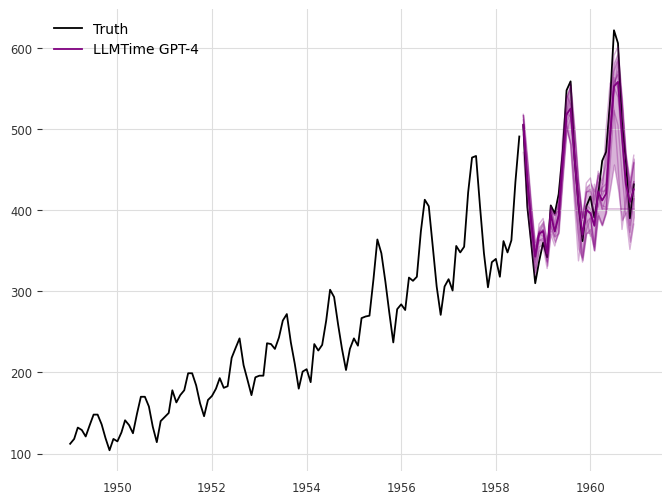

Train length: 86, Val length: 29


Hyperparameter search:   0%|          | 0/4 [00:00<?, ?it/s]/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0, 'dataset_name': 'AirPassengersDataset'}) 
 with NLL 3.747898


/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/william/anaconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


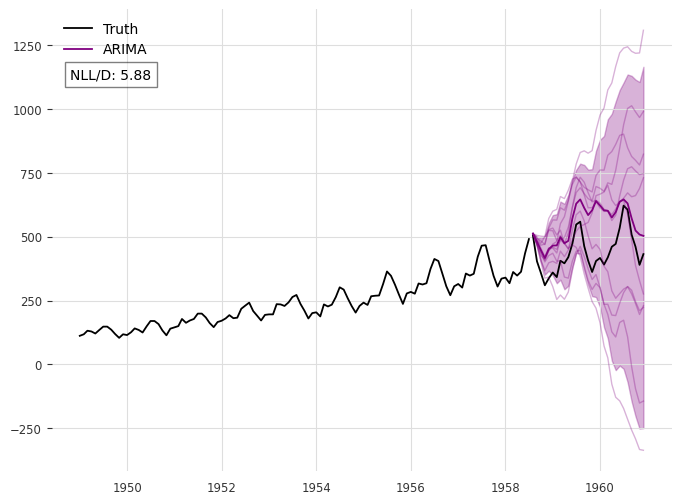

In [16]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10
    pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    plot_preds(train, test, pred_dict, model, show_samples=True)